## Libraries

### Library Index

Data structure libraries
* Numpy. Since Machine Learning algorithms only receive data in the shape of a Matrix array, numpy will help us creating them. It comes with data manipulation and mathematical functions that will become handy for data preparation.
* Pandas. Before converting our data into Numpy arrays. Pandas Dataframes will help us during the Data Preparation phase. It arranges the data in tabular format for easy exploration and manipulation.

Data Visualization libraries
* Seaborn. This library is based on matplotlib and provides a high level interface for drawing attractive and informative statistical graphics.
* Matplot. It's a collection of command style functions designed to plot numpy arrays and dataframe the way that MATLAB works.
* Scikitplot. Based on Matplot, it helps plotting Scikit Learn objects easily to provide meaningful and interpretable visualizations of ML performance metrics.

Machine Learning Libraries
* Scikit-Learn. Free software machine learning library.
* Yellowbrick. Yellowbrick extends the Scikit-Learn API to make model selection and hyperparameter tuning easier. Under the hood, it’s using Matplotlib.
* MlXtend. (machine learning extensions) is a Python library of useful tools for the day-to-day data science tasks.
* Tensorflow. Free and open-source software library for dataflow and differentiable programming across a range of tasks. It is a symbolic math library, and is also used for machine learning applications such as neural networks.


In [1]:
import datetime
import numpy as np
np.random.seed(42)
random_state=42
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import *
import matplotlib.patheffects as PathEffects
%matplotlib inline
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, MinMaxScaler, RobustScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import * 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick import ROCAUC
from mlxtend.evaluate import lift_score
from matplotlib import colors
from matplotlib.colors import ListedColormap
from IPython.display import HTML, display
import tabulate
import scikitplot as skplt
import tensorflow as tf
import gc
print(__doc__)
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

/home/swadm/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Automatically created module for IPython interactive environment


## Data Preparation Functions

### Functions Index

* Extract Categories. 
<br>1) Separate features.
<br>2) Determines Data Type
<br>3) Sets Column Cardinality
<br>4) Separates columns into low and high cardinality
<br>5) Returns numerical and categorical features back to the caller
<br>This functions searches for the column called START, and everything to the right will be consider a candidate feature the developer is trying to use to predict employee resignation. Datasets tend to come with irrelevant columns and extra pieces of information that is unnecessary for the ML Algorithm to consume. By placing these columns to the left of the START, we ensure we only process the relevant features. The function also determines the datatype automatically and upon finding a categorical variable, determines the best encoding technique based on the desired cardinality level. Saves the list of columns into 2 lists, cat_features for categorical (1,0) and loo_encode for LeaveOneOut (probability). Cat_prefixes contains a list of the prefixes the columns will have after getting converted into numbers.
<br>
<br>
* Train Test Split.
<br>Does Stratified Shuffle, reducing the standard error when splitting.
<br>
<br>
* OH encode.
<br> Transforms the columns to 0's and 1's
<br>
<br>
* Bin encode.
<br> Transforms the columns to binary encoding
<br>
<br>
* LOO encode. 
<br>1) Sets the desired Train-Test ratio (80% Train, 20% Test)
<br>2) Based on the target column, determines the probability of resignation
<br>3) Implements Leave One Out encoding to ensure no data leak.
<br>This function encodes the categorical features that present high cardinality and performs the data split into Train and Test sets. This function uses h2o library, n open-source, distributed in-memory machine learning platform with linear scalability.
<br>
<br>
* Prepare Features. 
<br>An extra step we need to perform is removing any non alphanumerical character resulted from the get_dummies() method. This is a requirement because some ML Algorithms do not accept JSON characters (LightGBM).
* Get Duplicate columns. 
<br>In some cases, the extract_categories() function, may produce duplicate columns. This method is no longer use but it could become handy if the phenomenon ocurrs again.

In [2]:
def extract_categories(df,cardinality=10):   
    cat_features=[]
    cat_prefixes=[]
    loo_features=[]
    dataTypes = pd.DataFrame(df.dtypes).reset_index()
    #Data type of each column of Dataframe :
    #                    index        0
    #0                  TARGET    int64
    for i in range(list(df.columns).index("START")+1,len(df.columns)):
        if (str(dataTypes.iloc[i][0])!='int64' and str(dataTypes.iloc[i][0])!='float64' and str(dataTypes.iloc[i][0])!='int32' and str(dataTypes.iloc[i][0])!='float32'):
            if df[str(dataTypes.iloc[i]['index'])].nunique()>cardinality:
                loo_features.append(str(dataTypes.iloc[i]['index']))   
            else:
                cat_features.append(str(dataTypes.iloc[i]['index']))
                cat_prefixes.append(str(dataTypes.iloc[i]['index']).replace("_", ""))
                #cat_prefixes.append(df.iloc[:, i].name.replace("_", ""))
    return cat_features,cat_prefixes,loo_features

In [3]:
def prepare_features(train_df,test_df,prod_df):
    import re
    train_df.columns = train_df.columns.str.replace("[-]", "_")
    train_df=train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    test_df.columns = test_df.columns.str.replace("[-]", "_")
    test_df=test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    prod_df.columns = prod_df.columns.str.replace("[-]", "_")
    prod_df=prod_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    features=[]
    for i in range(list(train_df.columns).index("START")+1,len(train_df.columns)):
        features.append(train_df.iloc[:, i].name)
    return features,train_df,test_df,prod_df

In [4]:
def train_test_split(df, test_pct=0.3, random_state=42, remove_old_records=False, cutoff='YEAR',target='TARGET'):
    import datetime
    year = datetime.datetime.today().year
    # Split the dataset into train and test using StratifiedShuffleSplit
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits = 2, test_size = test_pct, random_state=random_state)
    sss.get_n_splits(df)
    sss = StratifiedShuffleSplit(n_splits = 2, test_size = test_pct, random_state=random_state)

    for train_index, test_index in sss.split(df,df[target]):
        train_set2=df.iloc[train_index]
        test_set2=df.iloc[test_index]
    
    train_set3=train_set2.append(test_set2[test_set2[cutoff]!=str(year-1)])
    if remove_old_records:
        return train_set3, test_set2[test_set2[cutoff]==str(year-1)]
    return train_set2,test_set2

In [5]:
def oh_encode(train_df,test_df,cat_features,cat_prefixes,prod_df):
    if len(cat_features)==0:
        return train_df,test_df,prod_df
    train_df['SET']='TRAIN'
    test_df['SET']='TEST'
    new_df=train_df.append(test_df)
    new_df = pd.get_dummies(new_df, columns=cat_features, prefix=cat_prefixes) #ONEHOTENCODER OR ANY OTHER ENCODER
    new_prod = pd.get_dummies(prod_df, columns=cat_features, prefix=cat_prefixes)
    train_df=new_df[new_df['SET']=='TRAIN']
    test_df=new_df[new_df['SET']=='TEST']
    train_df=train_df.drop(['SET'],axis=1)
    test_df=test_df.drop(['SET'],axis=1)      
    return train_df, test_df, new_prod

In [6]:
def bin_encode(train_df,test_df,cat_features,prod_df):
    import category_encoders as ce
    if len(cat_features)==0:
        return train_df,test_df
    train_df['SET']='TRAIN'
    test_df['SET']='TEST'
    prod_df['SET']='PROD'
    new_df=train_df.append(test_df)
    encoder= ce.BinaryEncoder(cols=cat_features,return_df=True)
    #Fit and Transform Data 
    data_encoded=encoder.fit_transform(new_df)
    train_df=data_encoded[data_encoded['SET']=='TRAIN']
    test_df=data_encoded[data_encoded['SET']=='TEST']
    train_df=train_df.drop(['SET'],axis=1)
    test_df=test_df.drop(['SET'],axis=1)
    new_prod=encoder.transform(prod_df)
    new_prod=new_prod.drop(['SET'],axis=1)
    return train_df, test_df, new_prod

In [7]:
def loo_encode(train_df, test_df,loo_features,prod_df, target='TARGET'):   
    import h2o
    h2o.init(ip='localhost')
    from h2o.estimators import H2OTargetEncoderEstimator
    #https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging/target-encoding.html
    
    train = h2o.H2OFrame(train_df)
    test = h2o.H2OFrame(test_df)
    prod = h2o.H2OFrame(prod_df)

    # Set response column as a factor
    train['STATUS'] = train[target].asfactor()
    response='STATUS'
    #train, test = hf[hf['TARGET']==0].split_frame(ratios = [.8], seed = 1234)
    #train = train.rbind(hf[hf['TARGET']==1])

    # Choose which columns to encode
    encoded_columns = loo_features

    # Set target encoding parameters
    blended_avg= True
    inflection_point = 3
    smoothing = 10
    # In general, the less data you have the more regularization you need
    noise = 0.15

    # For k_fold strategy we need to provide fold column
    #data_leakage_handling = "k_fold"
    #fold_column = "kfold_column"
    #train[fold_column] = train.kfold_column(n_folds=5, seed=3456)

    data_leakage_handling = "leave_one_out"

    # Train a TE model
    df_te = H2OTargetEncoderEstimator(data_leakage_handling=data_leakage_handling,
                                           blending=blended_avg,
                                           k=inflection_point,
                                           f=smoothing)

    df_te.train(x=encoded_columns,y=response,training_frame=train)

    # New target encoded train and test sets
    train_te = df_te.transform(frame=train, data_leakage_handling="leave_one_out", seed=42, noise=noise)
    test_te = df_te.transform(frame=test, noise=0.0)  
    prod_te = df_te.transform(frame=prod, noise=0.0)  
    train_df=h2o.as_list(train_te)
    test_df=h2o.as_list(test_te)
    new_prod=h2o.as_list(prod_te)
    train_df = train_df.drop(loo_features, axis=1)
    test_df = test_df.drop(loo_features, axis=1)
    new_prod = new_prod.drop(loo_features, axis=1)
    train_df = train_df.drop(['STATUS'], axis=1)
    return train_df, test_df, new_prod

In [8]:
def leaveOneOut(train_df,test_df,loo_features,prod_df, target='TARGET'):
    from category_encoders import LeaveOneOutEncoder

    # create the encoder.
    LOO_encoder = LeaveOneOutEncoder(return_df=True)

    # fit and transform the data.
    new_x_train = LOO_encoder.fit_transform(train_df[loo_features], train_df[target])
    new_x_test = LOO_encoder.transform(test_df[loo_features])
    new_x_prod = LOO_encoder.transform(prod_df[loo_features])
    
    return new_x_train, new_x_test, new_x_prod

In [9]:
# This function take a dataframe 
# as a parameter and returning list 
# of column names whose contents  
# are duplicates. 
def getDuplicateColumns(df): 
  
    # Create an empty set 
    duplicateColumnNames = set() 
      
    # Iterate through all the columns  
    # of dataframe 
    for x in range(df.shape[1]): 
          
        # Take column at xth index. 
        col = df.iloc[:, x] 
          
        # Iterate through all the columns in 
        # DataFrame from (x + 1)th index to 
        # last index 
        for y in range(x + 1, df.shape[1]): 
              
            # Take column at yth index. 
            otherCol = df.iloc[:, y] 
              
            # Check if two columns at x & y 
            # index are equal or not, 
            # if equal then adding  
            # to the set 
            if col.equals(otherCol): 
                duplicateColumnNames.add(df.columns.values[y]) 
                  
    # Return list of unique column names  
    # whose contents are duplicates. 
    return list(duplicateColumnNames) 

In [10]:
def convert_to_numpy(train,test,feats,tgt,prod,tst=True):
    TrainX = train[feats].to_numpy()
    trainy = list(train[tgt].to_numpy())
    TestX = test[feats].to_numpy()
    testy = list(test[tgt].to_numpy())
    ProdX = prod[feats].to_numpy()
    prody = [0]
    if tst:
        prody=list(prod[tgt].to_numpy())
    return TrainX, trainy, TestX, testy, ProdX, prody

In [11]:
def prediction_decoding(train,test,feats,tgt,idx,prod, tst=True):
    validX=(train[train[tgt]==0][feats].append(test[test[tgt]==0][feats])).to_numpy()
    validy=(train[train[tgt]==0][tgt].append(test[test[tgt]==0][tgt])).to_numpy()
    
    if tst:
        valid_prod_X=prod[prod[tgt]==0][feats].to_numpy()
        valid_prod_y=prod[prod[tgt]==0][tgt].to_numpy()
    valid_prod_X=prod[feats].to_numpy()
    valid_prod_y=prod[tgt].to_numpy()
    
    test_idx=test.reset_index()
    test_idx['INDEX']=test_idx.index.tolist()
    df_valid=pd.DataFrame()
    df_valid=test_idx[idx]
    
    prod_idx=prod.reset_index()
    prod_idx['INDEX']=prod_idx.index.tolist()
    df_valid_prod=pd.DataFrame()
    df_valid_prod=prod_idx[idx]
    
    
    return validX,validy,df_valid,valid_prod_X,valid_prod_y,df_valid_prod

In [12]:
def get_counts(trainX,trainy,testX,testy,prodX,prody,tst=True):
    # define dataset for feature importance with over and under sampling
    X = trainX
    y = trainy
    X_tst = testX
    y_tst = testy
    X_prd = prodX
    y_prd = prody
    dimstrain = str(trainX.shape[1])+' columns x '+str(trainX.shape[0])+' rows'
    dimstest = str(testX.shape[1])+' columns x '+str(testX.shape[0])+' rows'
    dimsprod = str(prodX.shape[1])+' columns x '+str(prodX.shape[0])+' rows'
    print('---------COUNTING-----------')
    print('Train shape: ',format(dimstrain))  
    print('Test shape: ',format(dimstest))
    print('Prod shape: ',format(dimsprod))
    
    from collections import Counter
    counter = Counter(y)
    print('Train: ',format(counter))

    counter_tst = Counter(y_tst)
    print('Test: ',format(counter_tst))
    
    counter_prd = Counter(y_prd)
    print('Prod: ',format(counter_prd))
    return X,y,X_tst,y_tst,X_prd,y_prd

In [13]:
def roundup(x):
    import math
    lenint=str(x)
    ceilint='1'
    for i in range(len(lenint)-1):
        ceilint=ceilint+'0'
    return int(round(x/float(ceilint))*float(ceilint))

def solve_ratios(x):
    from fractions import gcd
    from functools import reduce
    numbers = [int(i) for i in x.split(':')]
    denominater = reduce(gcd,numbers)
    solved = [i/denominater for i in numbers]
    ratio_solved = ':'.join(str(int(i)) for i in solved)
    return ratio_solved

In [14]:
def implement_sampling(X,y,ratio_threshold=0.1,over_samp=0.4,under_samp=0.5):
    # Oversample with SMOTE and random undersample for imbalanced dataset
    from collections import Counter
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline
    from numpy import where
    # define dataset
    # summarize class distribution
    counter = Counter(y)
    print('---------SAMPLING-----------')
    print('Train: ',format(counter))
    #counter_tst = Counter(y_tst)
    #print('Test')
    #print(counter_tst)
    # define pipeline

    if counter[0]>counter[1]:
        majority_class=int(counter[0])
        minority_class=int(counter[1])
        ratios = str(counter[0])+':'+str(counter[1])
        ratios_solved=solve_ratios(ratios)
        ratio=round(int(counter[1])/int(counter[0]),2)*100
        print('% of the minority class (1) over the majority (0): ',format(round(ratio,2)))
    else:
        majority_class=int(counter[1])
        minority_class=int(counter[0])
        ratio=round(int(counter[0])/int(counter[1]),2)*100
        ratios_solved=solve_ratios(ratios)
        print('% of the minority class (0) over the majority (1): ',format(round(ratio,2)))


    if ratios_solved==ratios:
        rounded_ratios=str(roundup(majority_class))+':'+str(roundup(minority_class))
        ratios_solved=solve_ratios(rounded_ratios)
    
    print('Data ratio: ',format(ratios_solved))
    
        
    if ratio<ratio_threshold:
        over = SMOTE(sampling_strategy=over_samp)
        under = RandomUnderSampler(sampling_strategy=under_samp)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        # transform the dataset
        X, y = pipeline.fit_resample(X, y)
        #X_tst, y_tst = pipeline.fit_resample(X_tst, y_tst)
        # summarize the new class distribution
        counter = Counter(y)
        print('Post Over and Under sampling Train')
        print(counter)
    else:
        print("Oversampling not required")
    
    return X,y

In [15]:
def scale_dataset(method,X_train_arr,X_test_arr,X_prod_arr):
    from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler
    #X_train original numpy with no class imbalance treatment
    #X with class imbalance treatment
    #st_train if you used x_train as input then is Scaled features with no class imbalance
    #st_train if you used X as input, then is scaled with class imbalance
    if method=='StandardScaler':
        sc = StandardScaler()
    if method=='MinMaxScaler':
        sc = MinMaxScaler()
    if method=='RobustScaler':
        sc = RobustScaler()
    if method=='Normalizer':
        sc = Normalizer()
        
    train_st = sc.fit_transform(X_train_arr)
    test_st = sc.transform(X_test_arr)
    prod_st = sc.transform(X_prod_arr)
    return train_st,test_st,prod_st

## Data Preparation

### Data Preparation Index
* Import Data. 
<br>This step receives the Flat dataset summarizing Employee's history and accounting for the 1 year lag. employees.sql is the code to generate such dataset. Replace this code to Database connection, web services call or data streamming integration. Then we join the original dataset with another file generated from R. This dataset contains Managerial and HR Hierarchy features related to resignation ratios. Replace this code once these pieces of information have been generated within the same source.
* Data Split and Feature Encoding
<br>This step calls the Data Preparation functions and splits the dataset previously merged into train and test.
* Target declaration and Numpy Conversion.
<br>As is required by the machine learning algorithm. Every pipeline requires:
1. Features (X). Values to learn from.
2. Target (y). The label we want to predict.
3. Matrix array format. Using Numpy we convert the dataset into this format.

The basic formula we are trying to put together is the following:
Y= a + bX, where Y is the dependent variable (that's the variable that goes on the Y axis), X is the independent variable (i.e. it is plotted on the X axis), b is the slope of the line and a is the y-intercept.

### Importing Data

In [16]:
TARGET='TARGET'
IDENTIFY=['INDEX','EMPLID','UM_EMP_NK_SID','TARGET']

def load_data(tst=True, yearend=5):
    dfs = {}
    final_dfs=[]
    year = datetime.datetime.today().year
    yeartst=0
    if tst:
        yeartst=1
    yearstart=year-yeartst
    yearend-=yeartst
    prod_year=yearstart+1
    years=range(yearstart, yearstart - yearend, -1)
    
    #loading the production data set
    emp_prd=pd.read_csv('EDW_Employees_'+str(prod_year)+'.csv')
    res_prd=pd.read_csv('EDW_Resignations_'+str(prod_year)+'.csv')
    res_prd['EMPLID'] = res_prd['EMPLID'].astype(str)
    res_prd['EMPLID'] = np.where(res_prd['EMPLID'].str.len()==6,'UM0' + res_prd['EMPLID'], 'UM'+res_prd['EMPLID'])
    prod_df=pd.merge(emp_prd, res_prd, how='left', on=['EMPLID'])
    #actives=prod_df.loc[(prod_df['TARGET'] == 0)]
    #random=actives.sample(n=500)
    #prod_df=prod_df.loc[(prod_df['CLLG_ADM_UNT_LD'] == 'SCIENCE & ENGINEERING, COL OF') | (prod_df['CLLG_ADM_UNT_LD'] == 'SCIENCE/ENGINEERING, COL OF')]
    prod_df=prod_df.loc[(prod_df['TARGET'] == 1) | (prod_df['TARGET'] == 0)]
    #prod_df=prod_df.append(random)
    #prod_df = prod_df.sample(frac = 1) 
    prod_df.fillna(0, inplace=True)
    prod_df['PERCENT_RANK_JOB'] = prod_df.groupby('JOB_TTL')['MAX_SALARY'].rank(pct=True)
    prod_df['PERCENT_RANK_ZDEPT'] = prod_df.groupby('ZDEPTID_LD')['MAX_SALARY'].rank(pct=True)
    prod_df.insert(3, 'YEAR', str(yearstart))
    print('Loading production data set: EDW_Employees_'+str(prod_year))
    print('Loading production data set: EDW_Resignations_'+str(prod_year))

    for k in range(len(years)):
        pandas_ter='df_emp_'+str(years[k])
        pandas_res='df_res_'+str(years[k])
        csv_ter='EDW_Employees_'+str(years[k])+'.csv'
        csv_res='EDW_Resignations_'+str(years[k])+'.csv'
        dfs_merge='dfs_'+str(years[k])
        dfs[pandas_ter]=pd.read_csv(csv_ter)
        dfs[pandas_res]=pd.read_csv(csv_res)
        dfs[pandas_res]['EMPLID'] = dfs[pandas_res]['EMPLID'].astype(str)
        dfs[pandas_res]['EMPLID'] = np.where(dfs[pandas_res]['EMPLID'].str.len()==6,'UM0' + dfs[pandas_res]['EMPLID'], 'UM'+dfs[pandas_res]['EMPLID'])
        dfs[dfs_merge]=pd.merge(dfs[pandas_ter], dfs[pandas_res], how='left', on=['EMPLID'])
        dfs[dfs_merge]=dfs[dfs_merge].loc[(dfs[dfs_merge]['TARGET'] == 1) | (dfs[dfs_merge]['TARGET'] == 0)]
        dfs[dfs_merge].fillna(0, inplace=True)
        dfs[dfs_merge]['PERCENT_RANK_JOB'] = dfs[dfs_merge].groupby('JOB_TTL')['MAX_SALARY'].rank(pct=True)
        dfs[dfs_merge]['PERCENT_RANK_ZDEPT'] = dfs[dfs_merge].groupby('ZDEPTID_LD')['MAX_SALARY'].rank(pct=True)
        dfs[dfs_merge].insert(3, 'YEAR', str(years[k]-1))
        final_dfs.append(dfs[dfs_merge])
        print('Loading testing data set: EDW_Employees_'+str(years[k])+'.csv')
        print('Loading testing data set: EDW_Resignations_'+str(years[k])+'.csv')

    return pd.concat(final_dfs, ignore_index=True), prod_df
    
df, df_prd= load_data()

## Run algorithm for JUST FACULTY Employees
##df=df[df['JOB_CATGY_DESC']=='Faculty']
##df_prd=df_prd[df_prd['JOB_CATGY_DESC']=='Faculty']

Loading production data set: EDW_Employees_2020
Loading production data set: EDW_Resignations_2020
Loading testing data set: EDW_Employees_2019.csv
Loading testing data set: EDW_Resignations_2019.csv
Loading testing data set: EDW_Employees_2018.csv
Loading testing data set: EDW_Resignations_2018.csv
Loading testing data set: EDW_Employees_2017.csv
Loading testing data set: EDW_Resignations_2017.csv
Loading testing data set: EDW_Employees_2016.csv
Loading testing data set: EDW_Resignations_2016.csv


In [17]:
df_prd.to_csv("df_prd_11112020.csv", index = True)

In [18]:
df.to_csv("df_11112020.csv", index = True)

### Split, Encode, Numpify, Sampling and Scaling

In [19]:
#This method identifies the numerical vs categorical features and the cardinality of each feature
cat_features,cat_prefixes,loo_features=extract_categories(df,10)
#Split dataset in train and test
train_df,test_df = train_test_split(df, 0.2, random_state)
#binary encoding for columns with low cardinality
train_df,test_df,df_prd = bin_encode(train_df,test_df,cat_features,df_prd)
#Leave One Out encoding. Best algoritm for high cardinality features
train_df, test_df,df_prd = loo_encode(train_df,test_df,loo_features,df_prd)
#this method simply removes strange characters from the column names because some models won't accept them (LGBM)
features,train_df,test_df,df_prd=prepare_features(train_df,test_df,df_prd)
#examples on how to remove duplicate columns
#train_df=train_df.drop(columns = getDuplicateColumns(train_df))
#test_df=test_df.drop(columns = getDuplicateColumns(test_df))
#Models use numpy array formats, this function converts pandas dataframe to numpy array
X_train, y_train, X_test, y_test, X_pred, y_pred = convert_to_numpy(train_df,test_df, features,TARGET,df_prd)
#prepare a dataset to decode the predictions based on the index position of the prediction and emplid
X_valid,y_valid,valid_df,X_prod,y_prod,prod_df=prediction_decoding(train_df,test_df,features,TARGET,IDENTIFY,df_prd)
#Creating a duplicate of train, test, and getting counts of the class distribution
X,y,X_tst,y_tst,X_prd,y_prd=get_counts(X_train,y_train,X_test,y_test,X_pred,y_pred)
#Executing Synthetic Minority Oversampling Technique
#X,y=implement_sampling(X,y,1,0.4,0.5)
#This step is optional, and as such, we create yet another copy to be able to switch between optional scaling and no scaling. Please use this code to switch between the different scalers and evaluate the performance
st_train,st_test,st_pred=scale_dataset('StandardScaler',X_train,X_test,X_pred)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,52 days 4 hours 3 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,2 months and 7 days
H2O_cluster_name:,swadm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.409 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
targetencoder Model Build progress: |█████████████████████████████████████| 100%
---------COUNTING-----------
Train shape:  83 columns x 14829 rows
Test shape:  83 columns x 3708 rows
Prod shape:  83 columns x 15944 rows
Train:  Counter({0: 11897, 1: 2932})
Test:  Counter({0: 2975, 1: 733})
Prod:  Counter({0: 15060, 1: 884})


## Model Selection Functions

### Model Selection

In [20]:
from sklearn.model_selection import RandomizedSearchCV
def search_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False, search_mode = 'GridSearchCV', n_iterations = 10):
    fitted_model = None
    
    if(search_mode == 'GridSearchCV'):
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid, 
            cv=cv, 
            n_jobs=10, 
            scoring=scoring_fit,
            verbose=0
        )
        fitted_model = gs.fit(X_train_data, y_train_data)

    elif (search_mode == 'RandomizedSearchCV'):
        rs = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid, 
            cv=cv,
            n_iter=n_iterations,
            n_jobs=10, 
            scoring=scoring_fit,
            verbose=0,
            random_state=42
        )
        fitted_model = rs.fit(X_train_data, y_train_data)
    
    
    if(fitted_model != None):
        if do_probabilities:
            pred = fitted_model.predict_proba(X_test_data)
        else:
            pred = fitted_model.predict(X_test_data)
            
        return fitted_model, pred

### Feature Importance

In [21]:
def feature_importance(classifier, features):
    if classifier.best_estimator_:
        importance_cls = classifier.best_estimator_.feature_importances_
    else:
        importance_cls=classifier.feature_importances_
    # summarize feature importance
    featdict_cls={}
    for i,v in enumerate(importance_cls):
        featdict_cls[str(round(v,6))+' - '+features[i]]=v
        print('Feature: %0d %s, Score: %.5f' % (i,features[i],v))

    lists_cls=sorted(featdict_cls.items())
    feat_cls,score_cls = zip(*lists_cls)
    cls_features=pd.DataFrame()
    cls_features['coef']=score_cls
    cls_features['feature']=feat_cls
    plt.rcParams["figure.figsize"]=(20,10)
    pyplot.barh(feat_cls, score_cls)
    pyplot.figure(figsize=(8,6),dpi=80)
    pyplot.show()
    
def plot_coefficients_linear(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    return feature_names[top_coefficients],feature_names[top_coefficients]

def plot_coefficients(classifier, features, top_features=20, log=False):   
    if classifier.best_estimator_:
        importance_cls = classifier.best_estimator_.feature_importances_
    else:
        importance_cls=classifier.feature_importances_
    # summarize feature importance
    featdict_cls={}
    for i,v in enumerate(importance_cls):
        featdict_cls[str(round(v,6))+' - '+features[i]]=v
        #print('Feature: %0d %s, Score: %.5f' % (i,features[i],v))

    lists_cls=sorted(featdict_cls.items())
    feat_cls,score_cls = zip(*lists_cls)
    cls_features=pd.DataFrame()
    cls_features['coef']=score_cls
    cls_features['feature']=feat_cls
    
    top_positive_coefficients = cls_features.nlargest(top_features, 'coef')
    top_negative_coefficients = cls_features.nsmallest(top_features, 'coef')
    top_coefficients = top_positive_coefficients.append(top_negative_coefficients).reset_index()
    top_coefficients = top_coefficients.drop('index',axis=1)
    top_coefficients.loc[top_coefficients.index[top_coefficients.iloc[0:top_features].index], 'color'] = "blue"
    top_coefficients.loc[top_coefficients.index[top_coefficients.iloc[top_features:len(top_coefficients)].index], 'color'] = "red"
    #print(top_positive_coefficients)
    #print(top_negative_coefficients)

    fig, ax = subplots()
    top_coefficients.sort_values('coef', ascending=True).plot(kind='bar',x='feature',y='coef',sort_columns='coef',figsize=(15,5),legend=False,color=top_coefficients.color.map({'red': 'b', 'blue': 'r'}), ax=ax)
    if log:
        ax.set_yscale('log')
    plt.show()
    return top_positive_coefficients, top_negative_coefficients

### ML Performance Metrics

In [22]:
def prec_recall(model, acc, X_test, y_test, FCOLS,valid, threshold=0.5):
    print('***Search method Used:')
    print(model)
    model_name=str(model)
    print('***Threshold Used: {0}'.format(threshold))
    if threshold==0.5:
        y_pred = model.predict(X_test)
    else:
        predicted_proba = model.predict_proba(X_test)
        y_pred = (predicted_proba [:,1] >= threshold).astype('int')
    y_pred = np.array([int(round(x)) for x in y_pred])
    accuracy=accuracy_score(y_pred, y_test)
    if acc:
        accuracy=acc
    cm = confusion_matrix(y_test, y_pred)
    print('\n***Confusion Matrix:\n{0}'.format(cm))
    print('\n***How to read confusion matrix:')
    print(np.array([['True Negatives','False Positives'],['False Negatives','True Positives']]))
    report = classification_report(y_test, y_pred)
    print(report)
    
    
    pred_df=pd.DataFrame(y_pred,columns=['PREDICTION'])
    pred_df['INDEX']=pred_df.index.tolist()
    pred_x=pd.DataFrame(X_test,columns=FCOLS)
    pred_x['INDEX']=pred_x.index.tolist()
    pred_y=pd.DataFrame(y_test,columns=['TARGET_12M'])
    pred_y['INDEX']=pred_y.index.tolist()
    pred_xy=pd.merge(pred_x, pred_y, how='inner', on=['INDEX'])
    pred_df_xy=pd.merge(pred_xy, pred_df, how='inner', on=['INDEX'])
    #print(pred_df_xy[pred_df_xy['PREDICTION']==1])
    results_df=valid.merge(pred_df)
    results_df['RESULT']=np.where(results_df['TARGET_12M']==results_df['PREDICTION'],'CORRECT','WRONG')
    print('\n***RESIGNATIONS PREDICTED: {0}'.format(len(results_df[(results_df['RESULT']=='CORRECT')&(results_df['TARGET_12M']==1)])))
    print(results_df.loc[(results_df['RESULT']=='CORRECT')&(results_df['TARGET_12M']==1),['EMPLID','EMPLOYEE_STATUS_12M','TARGET_12M','PREDICTION','RESULT']])
    
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, ["Active", "Terminated"], rotation=-45, size = 10)
    plt.yticks(tick_marks, ["Active", "Terminated"], size = 10)
    plt.ylabel('Actual label', size = 15)
    plt.xlabel('Predicted label', size = 15)
    all_sample_title = 'Accuracy Score for {0}: {1}'.format(model_name,accuracy)#model.best_score_)
    plt.title(all_sample_title, size = 10);    
    
def prec_recall_compare(model, acc, X_test, y_test, y_test3, y_test6, FCOLS):
    print('***Search method Used:')
    print(model)
    
    y_pred = model.predict(X_test)
    y_pred = np.array([int(round(x)) for x in y_pred])
    
    print('\n***How to read confusion matrix:')
    print(np.array([['True Negatives','False Positives'],['False Negatives','True Positives']]))
    
    
    cm = confusion_matrix(y_test, y_pred)
    print('\n***Confusion Matrix 6 Month:\n{0}'.format(cm))
    cm3 = confusion_matrix(y_test3, y_pred)
    print('\n***Confusion Matrix 9 Month:\n{0}'.format(cm3))
    cm6 = confusion_matrix(y_test6, y_pred)
    print('\n***Confusion Matrix 12 Month:\n{0}'.format(cm6))
    report = classification_report(y_test, y_pred)
    print('\n***Report 6 Month:\n{0}'.format(report))
    report3 = classification_report(y_test3, y_pred)
    print('\n***Report 9 Month:\n{0}'.format(report3))
    report6 = classification_report(y_test6, y_pred)
    print('\n***Report 12 Month:\n{0}'.format(report6))
    
def classification_report_heatmap(model,X_train,y_train,X_test,y_test):
    fig, ax = plt.subplots()
    visualizer = ClassificationReport(model, classes=[0, 1], ax=ax)
    ax.grid(False)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    for label in visualizer.ax.texts:
        label.set_size(14)
    visualizer.show()

def plot_classification_report(model,X_test_data,y_test_data,threshold=0.50,title=None):
    ddl_heat = ['#DBDBDB','#DCD5CC','#DCCEBE','#DDC8AF','#DEC2A0','#DEBB91',\
            '#DFB583','#DFAE74','#E0A865','#E1A256','#E19B48','#E29539']
    ddlheatmap = colors.ListedColormap(ddl_heat)
    cmap=ddlheatmap
    
    y_pred_out = model.predict_proba(X_test_data)
    y_pred_proba = y_pred_out[:,1]
    if threshold!=0.50:
        predicted_proba = model.predict_proba(X_test_data)
        y_pred_proba = (predicted_proba[:,1] >= threshold).astype('int')
        
    y_pred_proba = np.array([int(round(x)) for x in y_pred_proba])
    cr = classification_report(y_test_data, y_pred_proba)
    title = title or 'Classification report for: '+str(model)
    lines = cr.split('\n')
    classes = []
    matrix = []
    for line in lines[2:(len(lines)-3)]:
        s = line.split()
        try:
            classes.append(s[0])
            value = [float(x) for x in s[1: len(s) - 1]]
            matrix.append(value)
        except IndexError:
            break;
    fig, ax = plt.subplots(1)
    
    for column in range(len(matrix)+1):
        for row in range(len(classes)):
            try:
                txt = '%.2f' % matrix[row][column]
                if (column==0)&(row==1):
                    if matrix[row][column]>=0.50:
                        ax.text(column,row,txt,va='center',ha='center',fontsize=14, fontweight='bold', bbox=dict(facecolor='green', edgecolor='gray', boxstyle='round,pad=1'))
                    else:
                        ax.text(column,row,txt,va='center',ha='center',fontsize=14, fontweight='bold', bbox=dict(facecolor='red', edgecolor='gray', boxstyle='round,pad=1'))
                else:
                    ax.text(column,row,txt,va='center',ha='center',fontsize=14, fontweight='bold',
                       bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=1'))
            except IndexError:
                break;
    cmap_reversed = matplotlib.cm.get_cmap('Blues')
    fig = plt.imshow(matrix, interpolation='nearest', cmap=cmap_reversed)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(len(classes)+1)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()

In [23]:
def show_quarter(df, query, col, title, ax, bins, x_label=None, y_label=None):
    results = df.query(query)
    results[col].hist(ax=ax, bins=bins); 
    if y_label:
        ax.set_ylabel(y_label)
    if x_label:
        ax.set_xlabel(x_label)
    ax.set_title(title + " ({})".format(results.shape[0])) #IANBOB
    
def plot_confusion_matrix_histograms(model,X_test,y_test,threshold=0.50):
    counter_test = Counter(y_test)
    y_pred_out = model.predict_proba(X_test)
    y_pred_proba = y_pred_out[:,1]
    if threshold!=0.50:
        predicted_proba = model.predict_proba(X_test)
        y_pred_proba = (predicted_proba[:,1] >= threshold).astype('int')
    df_predictions = pd.DataFrame({'y': y_test, 'y_proba': y_pred_proba})
    fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
    # show true-pos
    bins = np.arange(0, 1.01, 0.1)
    show_quarter(df_predictions, "y==0 and y_proba < 0.5", "y_proba", "True Negative", axs[0][0], bins, y_label="Actual Active")
    show_quarter(df_predictions, "y==0 and y_proba >= 0.5", "y_proba", "False Positive", axs[0][1], bins)
    show_quarter(df_predictions, "y==1 and y_proba >= 0.5", "y_proba", "True Positive", axs[1][1], bins, x_label="Predicted Resignations")
    show_quarter(df_predictions, "y==1 and y_proba < 0.5", "y_proba", "False Negative", axs[1][0], bins, x_label="Predicted Active", y_label="Actual Resignations")
    fig.suptitle("Probabilities per Confusion Matrix cell with Threshold: {0} Support: 0={1} 1={2}".format(threshold,counter_test[0],counter_test[1]));  

### ML Performance Charts

In [24]:
def plot_lift_curve(model,X_test,y_test,threshold=0.50):    
    y_pred = model.predict_proba(X_test)
    y_pred_proba = y_pred[:,1]
    if threshold!=0.50:
        y_pred = model.predict_proba(X_test)
        y_pred_proba = (y_pred[:,1] >= threshold).astype('int')
    y_pred_score = np.array([int(round(x)) for x in y_pred_proba])
    ls=lift_score(y_test, y_pred_score)
    
    skplt.metrics.plot_lift_curve(y_true=y_test, y_probas=y_pred)
    plt.title('Lift Curve - Score: {0}'.format(round(ls,2)))
    plt.show()
    
def plot_Lift_curve(model,X_test,y_test, step=0.01, threshold=0.50):
    y_pred_proba = model.predict_proba(X_test)
    y_pred=y_pred_proba[:,1]
    if threshold!=0.50:
        predicted_proba = model.predict_proba(X_test)
        y_pred_proba = (predicted_proba[:,1] >= threshold).astype('int')
        y_pred=y_pred_proba
    
    y_pred_score=np.array([int(round(x)) for x in y_pred])
    ls=lift_score(y_test, y_pred_score)
    y_val=y_test
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve - Score: {0}'.format(round(ls,2)))
    plt.show()

def prec_recall_curve(model,X_train,y_train,X_test,y_test):

    from yellowbrick.classifier import PrecisionRecallCurve
    from yellowbrick.datasets import load_spam

    # Create the visualizer, fit, score, and show it
    viz = PrecisionRecallCurve(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()
    
def plot_pr_curve(model,testX,testy):
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    y_score = model.decision_function(testX)
    average_precision = average_precision_score(testy, y_score)
    disp = plot_precision_recall_curve(model,testX,testy)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(average_precision))

def plot_ROCAUC(model,X_train,y_train,X_test,y_test):
    visualizer = ROCAUC(model, micro=False, macro=False, per_class=True)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    g = visualizer.poof()             # Draw/show/poof the data
    return visualizer

### Thresholding

In [25]:
def plot_discrimination_threshold(model,X_train,y_train):
    visualizer = DiscriminationThreshold(model)
    visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
    visualizer.show()           # Finalize and render the figure

### Extract Predicted Employees

In [26]:
def get_predictions(model, testX, testy, FCOLS,valid, threshold=0.5):
    if threshold==0.5:
        y_pred = model.predict(testX)
    else:
        predicted_proba = model.predict_proba(testX)
        y_pred = (predicted_proba [:,1] >= threshold).astype('int')
    pred_df=pd.DataFrame(y_pred,columns=['PREDICTION'])
    pred_df["PROBAS"]=predicted_proba [:,1]
    pred_df['INDEX']=pred_df.index.tolist()
    pred_x=pd.DataFrame(testX,columns=FCOLS)
    pred_x['INDEX']=pred_x.index.tolist()
    pred_y=pd.DataFrame(testy,columns=['TARGET'])
    pred_y['INDEX']=pred_y.index.tolist()
    pred_xy=pd.merge(pred_x, pred_y, how='inner', on=['INDEX'])
    pred_df_xy=pd.merge(pred_xy, pred_df, how='inner', on=['INDEX'])
    #print(pred_df_xy[pred_df_xy['PREDICTION']==1])
    results_df=valid.merge(pred_df)
    results_df['RESULT']=np.where(results_df['TARGET']==results_df['PREDICTION'],'CORRECT','WRONG')
    print('RESIGNATIONS PREDICTED: {0}'.format(len(results_df[(results_df['RESULT']=='CORRECT')&(results_df['TARGET']==1)])))
    #display(HTML(tabulate.tabulate(results_df.loc[(results_df['RESULT']=='CORRECT')&(results_df['TARGET_12M']==1),['EMPLID','EMPLOYEE_STATUS_12M','TARGET_12M','PREDICTION','RESULT']], tablefmt='html')))
    output=results_df.loc[(results_df['RESULT']=='CORRECT')&(results_df['TARGET']==1),['EMPLID','UM_EMP_NK_SID','TARGET','PREDICTION','RESULT']]
    display(HTML(output.to_html()))
    return results_df
    
def get_predictions_prod(model, prodX, prody, FCOLS,valid, threshold=0.5):
    if threshold==0.5:
        y_pred = model.predict(prodX)
    else:
        predicted_proba = model.predict_proba(prodX)
        y_pred = (predicted_proba [:,1] >= threshold).astype('int')
    pred_df=pd.DataFrame(y_pred,columns=['PREDICTION'])
    pred_df["PROBAS"]=predicted_proba [:,1]
    pred_df['INDEX']=pred_df.index.tolist()
    pred_x=pd.DataFrame(prodX,columns=FCOLS)
    pred_x['INDEX']=pred_x.index.tolist()
    pred_y=pd.DataFrame(prody,columns=['TARGET'])
    pred_y['INDEX']=pred_y.index.tolist()
    pred_xy=pd.merge(pred_x, pred_y, how='inner', on=['INDEX'])
    pred_df_xy=pd.merge(pred_xy, pred_df, how='inner', on=['INDEX'])
    #print(pred_df_xy[pred_df_xy['PREDICTION']==1])
    results_df=valid.merge(pred_df)
    results_df['RESULT']=np.where(results_df['TARGET']==results_df['PREDICTION'],'CORRECT','WRONG')
    print('RESIGNATIONS PREDICTED: {0}'.format(len(results_df[(results_df['RESULT']=='CORRECT')&(results_df['TARGET']==1)])))
    #display(HTML(tabulate.tabulate(results_df.loc[(results_df['RESULT']=='CORRECT')&(results_df['TARGET_12M']==1),['EMPLID','EMPLOYEE_STATUS_12M','TARGET_12M','PREDICTION','RESULT']], tablefmt='html')))
    output=results_df.loc[(results_df['RESULT']=='CORRECT')&(results_df['TARGET']==1),['EMPLID','UM_EMP_NK_SID','TARGET','PREDICTION','RESULT']]
    display(HTML(output.to_html()))
    return results_df

## Generate predictions and obtain probabilities

In [33]:
## Get predictions for all of testing data (2015 - 2019)

testing_df_results = get_predictions(model_XGB, st_test, y_test, features, valid_df, threshold=0.6)

RESIGNATIONS PREDICTED: 512


,EMPLID,UM_EMP_NK_SID,TARGET,PREDICTION,RESULT
4,UM1442604,6573,1,1,CORRECT
9,UM5111746,94866,1,1,CORRECT
11,UM8004769,151389,1,1,CORRECT
13,UM4752470,72060,1,1,CORRECT
23,UM4110274,40501,1,1,CORRECT
24,UM2970954,22676,1,1,CORRECT
26,UM5164142,101837,1,1,CORRECT
28,UM3912243,36807,1,1,CORRECT
30,UM4382784,51745,1,1,CORRECT
32,UM1872433,11622,1,1,CORRECT


In [34]:
## Read in the datafile containing the Employee Information required for the CSV

test_employee_information_df = pd.read_csv("df_11112020.csv")

In [35]:
test_employee_information_df = test_employee_information_df.rename(columns={"Unnamed: 0": "INDEX"})

In [37]:
test_employee_information_df.columns

Index(['INDEX', 'TARGET', 'EMPLID', 'UM_EMP_NK_SID', 'YEAR', 'START',
       'PERS_AGE', 'EMP_DSBL_IND', 'EMP_PRTCT_VTRN_IND', 'INST_CALC_ETHN_DESC',
       'LGL_SX_CD', 'JOB_IND', 'COMP_FREQ_DESC', 'FULL_PRT_TIME_CD',
       'TENURE_FLG', 'TENURE_TRK_FLG', 'PHSD_RTRMNT_IND', 'EMP_PYMNT_TP_DESC',
       'BRGN_UNT_DESC', 'EMP_CNTR_TP_DESC', 'EMP_CLSS_DESC',
       'IPED_JOB_CATGY_DESC', 'REG_TEMP_CD', 'CMP_LD', 'LOCATION',
       'JOB_CATGY_DESC', 'WKFC_CATGY_DESC', 'POS_TTL', 'JOB_TTL', 'JOB_FAM_LD',
       'ZDEPTID_LD', 'CLLG_ADM_UNT_LD', 'TOTAL_SECONDARY_JOBS',
       'TOTAL_PRIMARY_JOBS', 'TOTAL_JOB_CYCLES', 'TOTAL_TERMINATIONS',
       'JOB_RECLASSIFICATIONS', 'POSITION_CHANGES', 'PAY_RATE_CHANGES',
       'TOTAL_ADDL_PAYMENTS', 'TRANSFERS', 'MAX_SALARY', 'MIN_SALARY',
       'DAYS_SINCE_INCR', 'SUPERVISORS_COUNT', 'DURATION',
       'lifetime_manager_count', 'lifetime_JOB_TTL', 'lifetime_POS_TTL',
       'lifetime_ZDEPTID_LD', 'lifetime_employee_count',
       'resigned_employee_c

## Subset the dataframe for the specific columns that are required - just for the test set.

In [48]:
test_employee_information_subset_df = \
test_employee_information_df[["INDEX", "EMPLID", "CMP_LD", "CLLG_ADM_UNT_LD", "ZDEPTID_LD", ## Where they work
                
    "LGL_SX_CD", "PERS_AGE", "INST_CALC_ETHN_DESC", "EMP_DSBL_IND", "EMP_PRTCT_VTRN_IND", ## Employee's Demographics
    
    "JOB_CATGY_DESC", "IPED_JOB_CATGY_DESC", "JOB_FAM_LD", "JOB_TTL", "POS_TTL", # Employee's job type
        
    "DAYS_SINCE_INCR", "PAY_RATE_CHANGES", "MAX_SALARY", "COMP_FREQ_DESC", "EMP_PYMNT_TP_DESC", ## Employee's pay
    
    "DURATION", "TENURE_FLG", "TENURE_TRK_FLG"  ## Employee's length of service                     
                             ]]

In [49]:
test_employee_information_subset_df

,INDEX,EMPLID,CMP_LD,CLLG_ADM_UNT_LD,ZDEPTID_LD,LGL_SX_CD,PERS_AGE,INST_CALC_ETHN_DESC,EMP_DSBL_IND,EMP_PRTCT_VTRN_IND,...,JOB_TTL,POS_TTL,DAYS_SINCE_INCR,PAY_RATE_CHANGES,MAX_SALARY,COMP_FREQ_DESC,EMP_PYMNT_TP_DESC,DURATION,TENURE_FLG,TENURE_TRK_FLG
0,0,UM0607608,TWIN CITIES,MEDICAL SCHOOL - TC CAMPUS,Radiology,M,77,White,N,Y,...,Associate Professor,Associate Professor,0,0,72635.16000,Biweekly,Salaried,44,N,N
1,1,UM0638920,TWIN CITIES,MEDICAL SCHOOL - TC CAMPUS,Neurology,F,74,White,N,N,...,Executive Ofc and Admin Spec,Executive Ofc and Admin Spec,-353,6,55764.80000,Hourly,Exception Hourly,18,N,N
2,2,UM0655149,TWIN CITIES,"SCIENCE & ENGINEERING, COL OF",CSENG Physics & Astronomy,M,75,White,N,N,...,Professor,Professor,-276,3,145914.00000,Bi-Weekly - 9 Month,Salaried,33,Y,N
3,3,UM0643043,TWIN CITIES,BOYNTON HEALTH SERVICE,Boynton Health Service,F,68,White,N,N,...,Mental Health Care Provider 1.,Mental Health Care Provider 1,-353,3,91664.33796,Biweekly,Salaried,37,N,N
4,4,UM0652102,TWIN CITIES,"LIBERAL ARTS, COLLEGE OF",CLA Psychology,M,76,White,N,Y,...,Professor,Professor,-353,3,121611.00000,Biweekly,Salaried,46,Y,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18532,18532,UM8000048,TWIN CITIES,"PHARMACY, COLLEGE OF",PHARM Medicinal Chemistry,F,31,White,N,N,...,Prin Ofc & Admin Specialist,Prin Ofc & Admin Specialist,0,0,35235.20000,Hourly,Exception Hourly,0,N,N
18533,18533,UM8000085,TWIN CITIES,INFORMATION TECHNOLOGY,OIT End User Support Services,M,38,Asian,N,N,...,End User Support 1,End User Support 1,0,0,50003.20000,Hourly,Exception Hourly,0,N,N
18534,18534,UM8000238,TWIN CITIES,BOYNTON HEALTH SERVICE,Boynton Health Service,F,40,White,N,N,...,Nursing Professional,Registered Nurse,0,0,56992.00000,Hourly,Exception Hourly,0,N,N
18535,18535,UM8000335,TWIN CITIES,"FOOD, AGRI/NAT RSRC SCI, COLL",CFANS Forest Resources,M,43,White,N,N,...,Research Fellow,Research Fellow,0,0,39900.00000,Biweekly,Salaried,0,N,N


In [50]:
## Use 20% of the overall data set to test the model outcomes
## Using the XGBoost Model

## Merge the predictions and probabilities with the information for the College and Job Category
merged_test_df = testing_df_results.merge(test_employee_information_subset_df, how = "left", on = "INDEX")

In [51]:
## Get just the Faculty set of data

fa_test_df = merged_test_df[merged_test_df["JOB_CATGY_DESC"] == "Faculty"]

In [52]:
fa_test_df.to_csv("fa_testing_set_11_11_2020.csv")

In [53]:
## Get prediction simulating 2020 run

production_results_df = get_predictions_prod(model_XGB, st_pred, y_prod, features, prod_df, threshold=0.6)

RESIGNATIONS PREDICTED: 41


,EMPLID,UM_EMP_NK_SID,TARGET,PREDICTION,RESULT
1841,UM1369707,5740,1,1,CORRECT
1903,UM1384760,5883,1,1,CORRECT
8643,UM3381888,27115,1,1,CORRECT
9364,UM3591062,30606,1,1,CORRECT
9460,UM3624985,31091,1,1,CORRECT
9681,UM3704615,32430,1,1,CORRECT
10197,UM3860727,35507,1,1,CORRECT
10783,UM4036146,39409,1,1,CORRECT
11065,UM4179352,42530,1,1,CORRECT
11886,UM4501689,57089,1,1,CORRECT


## Subset the dataframe for the specific columns that are required - for the production set.

In [55]:
## Read in the datafile containing the Employee Information required for the CSV

employee_information_df = pd.read_csv("df_prd_11112020.csv")

employee_information_df = employee_information_df.rename(columns={"Unnamed: 0": "INDEX"})

In [56]:
employee_information_subset_df = \
employee_information_df[["INDEX", "EMPLID", "CMP_LD", "CLLG_ADM_UNT_LD", "ZDEPTID_LD", ## Where they work
                
    "LGL_SX_CD", "PERS_AGE", "INST_CALC_ETHN_DESC", "EMP_DSBL_IND", "EMP_PRTCT_VTRN_IND", ## Employee's Demographics
    
    "JOB_CATGY_DESC", "IPED_JOB_CATGY_DESC", "JOB_FAM_LD", "JOB_TTL", "POS_TTL", # Employee's job type
        
    "DAYS_SINCE_INCR", "PAY_RATE_CHANGES", "MAX_SALARY", "COMP_FREQ_DESC", "EMP_PYMNT_TP_DESC", ## Employee's pay
    
    "DURATION", "TENURE_FLG", "TENURE_TRK_FLG"  ## Employee's length of service                     
                             ]]

In [57]:
## Use 20% of the overall data set to test the model outcomes
## Using the XGBoost Model

## Merge the predictions and probabilities with the information for the College and Job Category
merged_prod_df = production_results_df.merge(employee_information_subset_df, how = "left", on = "INDEX")

In [58]:
print(len(production_results_df))
print(len(merged_prod_df))

15944
15944


In [59]:
## Get just the Faculty set of data

fa_prod_df = merged_prod_df[merged_prod_df["JOB_CATGY_DESC"] == "Faculty"]

In [60]:
fa_prod_df.head()

,INDEX,EMPLID_x,UM_EMP_NK_SID,TARGET,PREDICTION,PROBAS,RESULT,EMPLID_y,CMP_LD,CLLG_ADM_UNT_LD,...,JOB_TTL,POS_TTL,DAYS_SINCE_INCR,PAY_RATE_CHANGES,MAX_SALARY,COMP_FREQ_DESC,EMP_PYMNT_TP_DESC,DURATION,TENURE_FLG,TENURE_TRK_FLG
2,2,UM0552832,84,0,0,0.000152,CORRECT,UM0545900,DULUTH,"UMD LIBERAL ARTS, COLLEGE OF",...,Instructor,Instructor,-354.0,4.0,47355.00,Biweekly,Salaried,32.0,N,N
5,5,UM0558848,124,0,0,0.000191,CORRECT,UM0552832,TWIN CITIES,MEDICAL SCHOOL - TC CAMPUS,...,Professor,Professor,-1082.0,0.0,260710.04,Biweekly,Salaried,9.0,Y,N
6,6,UM0607608,136,0,0,0.003932,CORRECT,UM0552832,TWIN CITIES,MEDICAL SCHOOL - TC CAMPUS,...,Head (With Faculty Rank),Head (With Faculty Rank),-1082.0,1.0,260710.04,Biweekly,Salaried,9.0,Y,N
11,11,UM0655149,191,0,0,0.000012,CORRECT,UM0607608,TWIN CITIES,MEDICAL SCHOOL - TC CAMPUS,...,Associate Professor,Associate Professor,0.0,0.0,72635.16,Biweekly,Salaried,45.0,N,N
14,14,UM0655274,194,0,0,0.000015,CORRECT,UM0652102,TWIN CITIES,"LIBERAL ARTS, COLLEGE OF",...,Professor,Professor,-354.0,4.0,124224.00,Biweekly,Salaried,47.0,Y,N


## Deliver the final results in a CSV format.

In [61]:
fa_prod_df.to_csv("fa_prod_set_11_11_2020.csv")

## Model Selection

### XGBoost GridSearch

In [27]:
from xgboost import XGBClassifier
class_weight = {0:1,1:17}
#Cost Learning attempt did not went well
#model_XGBgs = XGBClassifier(scale_pos_weight=50)
model_XGBgs = XGBClassifier()

param_grid_XGB = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 2, 5],
        'subsample': [0.75],
        'colsample_bytree': [0.75, 1.0],
        'max_depth': [3, 10],
        'scale_post_weight': [30]
        }

#        'scale_post_weight': [1,10,15,30]
#'class_weight':[{1: w} for w in [5,10,15,20]]

model_XGB, pred_XGB = search_pipeline(st_train, st_test, y_train, y_test, model_XGBgs,param_grid_XGB, cv=5,scoring_fit='recall',search_mode = 'RandomizedSearchCV')

print(model_XGB.best_score_)
print(model_XGB.best_params_)

[10:21:19] WARNING: ../src/learner.cc:516: 
Parameters: { scale_post_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.7152147496089911
{'subsample': 0.75, 'scale_post_weight': 30, 'min_child_weight': 1, 'max_depth': 10, 'gamma': 0.5, 'colsample_bytree': 1.0}


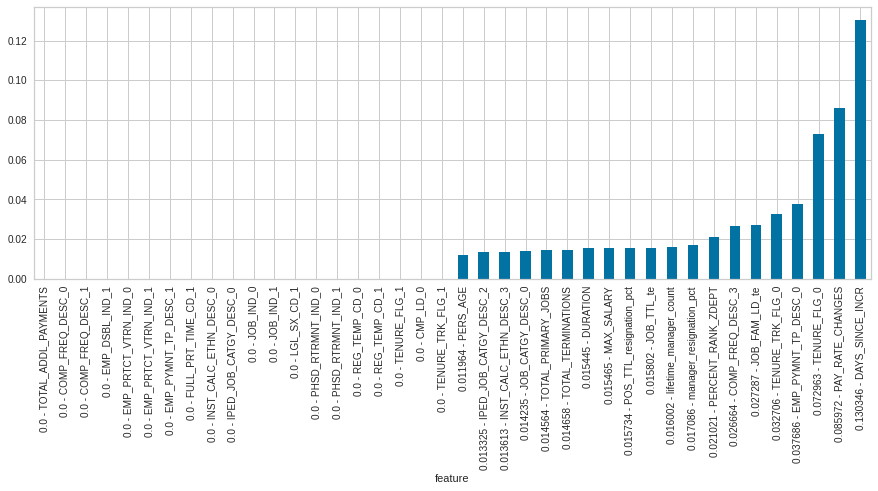

In [28]:
top_XGB,bottom_XGB=plot_coefficients(model_XGB, features, top_features=20)

20% Test report


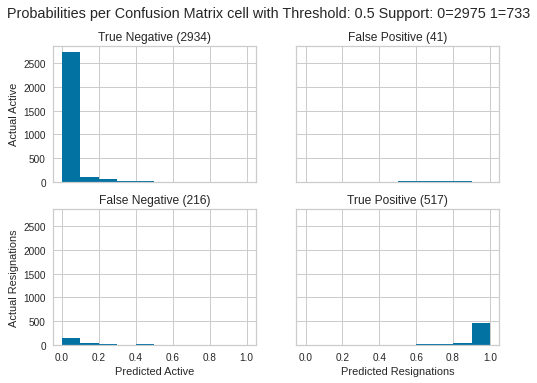

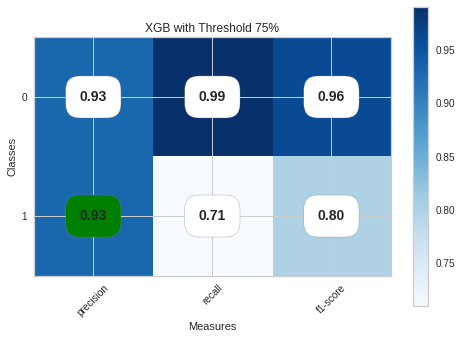

In [29]:
print("20% Test report")
plot_confusion_matrix_histograms(model_XGB,st_test,y_test,0.50)
plot_classification_report(model_XGB,st_test,y_test,0.50,title="XGB with Threshold 75%")

Full Production Report


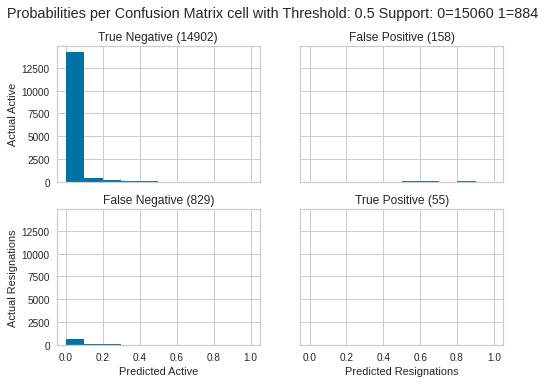

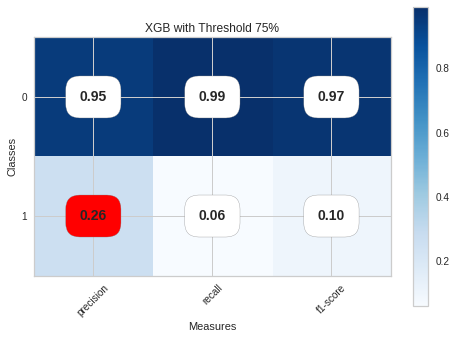

In [41]:
print("Full Production Report")
plot_confusion_matrix_histograms(model_XGB,st_pred,y_pred,0.50)
plot_classification_report(model_XGB,st_pred,y_pred,0.50,title="XGB with Threshold 75%")

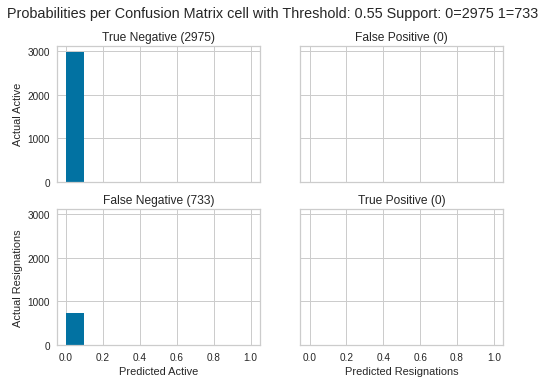

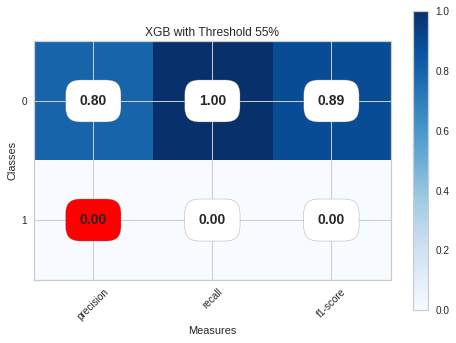

In [31]:
plot_confusion_matrix_histograms(model_XGB,X_test,y_test,0.55)
plot_classification_report(model_XGB,X_test,y_test,0.55,title="XGB with Threshold 55%")
#plot_discrimination_threshold(model_XGB,X_train,y_train)

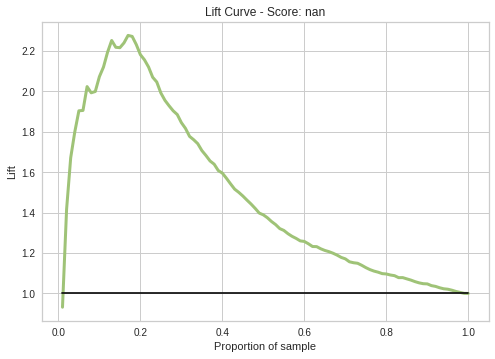

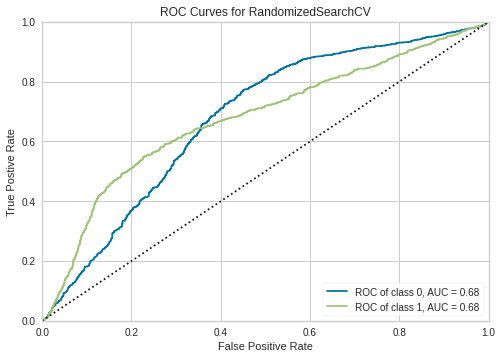

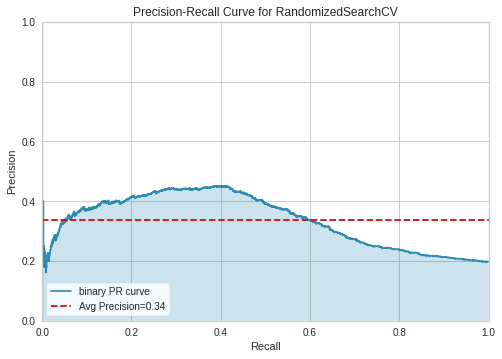

In [32]:
plot_Lift_curve(model_XGB,X_test,y_test)
plot_ROCAUC(model_XGB,X_train,y_train,X_test,y_test)
prec_recall_curve(model_XGB,X_train,y_train,X_test,y_test)

### Logistic Regression GridSearch

In [ ]:
from sklearn.linear_model import LogisticRegression
model_LRgs = LogisticRegression()
param_grid_LR = {"C":[1, 100, 10000], 
                 "penalty":["l1","l2"]}
model_LR, pred_LR = search_pipeline(X_train, X_test, y_train, y_test12, model_LRgs, 
                                 param_grid_LR, cv=5, scoring_fit='f1', search_mode='RandomizedSearchCV')

print(model_LR.best_score_)
print(model_LR.best_params_)

In [ ]:
plot_confusion_matrix_histograms(model_LR,X_test,y_test12,0.55)
plot_classification_report(model_LR,X_test,y_test12,0.55,title="LogisticRegression with Threshold 55%")

In [ ]:
plot_Lift_curve(model_LR,X_test,y_test12)
plot_ROCAUC(model_LR,X_train,y_train,X_test,y_test12)
prec_recall_curve(model_LR,X_train,y_train,X_test,y_test12)

### LightGBM GridSearch

In [ ]:
import lightgbm as lgb
model_LGBMgs = lgb.LGBMClassifier()
param_grid_LGBM= {
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.75, 1.0],
    'max_depth': [10, 20],
    'num_leaves': [50, 100, 200],
    'min_split_gain': [0.1, 0.4],
}
model_LGBM, pred_LGBM = search_pipeline(st_train, st_test, y_train, y_test, model_LGBMgs, 
                                 param_grid_LGBM, cv=5, scoring_fit='f1',search_mode='RandomizedSearchCV',n_iterations=10)

print(model_LGBM.best_score_)
print(model_LGBM.best_params_)

In [ ]:
top_LGBM,bottom_LGBM=plot_coefficients(model_LGBM, features, top_features=40, log=True)

In [ ]:
plot_confusion_matrix_histograms(model_LGBM,st_test,y_test,0.55)
plot_classification_report(model_LGBM,st_test,y_test,0.55,title="LightGBM with Threshold 55%")
#plot_discrimination_threshold(model_LGBM,st_train,y_train)

In [ ]:
plot_confusion_matrix_histograms(model_LGBM,st_pred,y_pred,0.75)
plot_classification_report(model_LGBM,st_pred,y_pred,0.75,title="LightGBM with Threshold 55%")

### Random Forest GridSearch

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_RFgs = RandomForestClassifier()

#Precision 1.0 for only 1 attempt and correctly predicted
#param_grid_RF = {
#    'n_estimators': [25, 50, 100],
#    'max_depth': [2,3,5],
#    'max_leaf_nodes': [2,5,10]
#}

param_grid_RF = {
    'n_estimators': [400, 700, 1000],
    'max_depth': [15,20,25],
    'max_leaf_nodes': [50, 100, 200]
}

model_RF, pred_RF = search_pipeline(X_train, X_test, y_train, y_test12, model_RFgs, 
                                 param_grid_RF, cv=5, scoring_fit='f1', search_mode='RandomizedSearchCV')

print(model_RF.best_score_)
print(model_RF.best_params_)

In [ ]:
top_RF,bottom_RF=plot_coefficients(model_RF, features, 40, log=True)

In [ ]:
plot_confusion_matrix_histograms(model_RF,X_test,y_test12,0.5)
plot_classification_report(model_RF,X_test,y_test12,0.5,title="RandomForest with Threshold 50%")
plot_discrimination_threshold(model_RF,X_train,y_train)

In [ ]:
plot_Lift_curve(model_RF,X_test,y_test12)
plot_ROCAUC(model_RF,X_train,y_train,X_test,y_test12)
prec_recall_curve(model_RF,X_train,y_train,X_test,y_test12)

### CatBoost GridSearch

In [ ]:
from catboost import CatBoostClassifier

model_CBgs = CatBoostClassifier(verbose=False)#task_type="GPU",devices='0:1')

#'ctr_border_count':[50,5,10,20,100,200],
param_grid_CB = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,20],
          'border_count':[32,5,10,20,40,100,200],
          'thread_count':[4]}

model_CB, pred_CB = search_pipeline(X_train, X_test, y_train, y_test12, model_CBgs, 
                                 param_grid_CB, cv=5, scoring_fit='f1',search_mode='RandomizedSearchCV')

print(model_CB.best_score_)
print(model_CB.best_params_)

In [ ]:
top_CB,bottom_CB=plot_coefficients(model_CB, features,40, log=True)

In [ ]:
plot_confusion_matrix_histograms(model_CB,X_test,y_test12,0.55)
plot_classification_report(model_CB,X_test,y_test12,0.55,title="CatBoost with Threshold 55%")
plot_discrimination_threshold(model_CB,X_train,y_train)

In [ ]:
plot_Lift_curve(model_CB,X_test,y_test12)
plot_ROCAUC(model_CB,X_train,y_train,X_test,y_test12)
prec_recall_curve(model_CB,X_train,y_train,X_test,y_test12)

### SVM Classifier

In [ ]:
from sklearn.svm import SVC
#from sklearn.svm import LinearSVC
model_SVMgs = SVC(probability=True)
param_grid_SVC = {'C': [1],  
              'gamma': [1], 
              'kernel': ['linear']}

#param_grid_SVC = {'C': [0.1, 1, 10, 100, 1000],  
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              #'kernel': ['linear']}
model_SVC, pred_SVC = search_pipeline(X_train, X_test, y_train, y_test, model_SVMgs, 
                                 param_grid_SVC, cv=5, scoring_fit='f1',search_mode = 'RandomizedSearchCV')

print(model_SVC.best_score_)
print(model_SVC.best_params_)

In [ ]:
top_SVC,bottom_SVC=plot_coefficients_linear(model_SVC.best_estimator_, features,40)

In [ ]:
plot_confusion_matrix_histograms(model_SVC,X_test,y_test,0.75)
plot_classification_report(model_SVC,X_test,y_test,0.75,title="SVM with Threshold 50%")
#plot_discrimination_threshold(model_SVC,X_train,y_train)

In [ ]:
plot_Lift_curve(model_SVC,X_test,y_test)
plot_ROCAUC(model_SVC,X_train,y_train,X_test,y_test)
prec_recall_curve(model_SVC,X_train,y_train,X_test,y_test)

### Stack Classifier

In [ ]:
import itertools
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Classifiers
from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier # <- Here is our boy

# Used to ignore warnings generated from StackingCVClassifier
import warnings
warnings.simplefilter('ignore')






#param_grid_XGB = {
        #'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 2, 5],
        #'subsample': [0.75],
        #'colsample_bytree': [0.75, 1.0],
        #'max_depth': [3, 10]
        #}

# Initializing Support Vector classifier
#classifier1 = SVC(C = 50, degree = 1, gamma = "auto", kernel = "rbf", probability = True)
classifier1 = SVC(C = 1, degree = 1, gamma = 1, kernel = "rbf", probability = True)

# Initializing Multi-layer perceptron  classifier
classifier2 = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)

# Initialing Nu Support Vector classifier
classifier3 = NuSVC(degree = 1, kernel = "rbf", nu = 0.10, probability = True)

#{'n_estimators': 100, 'max_leaf_nodes': 2, 'max_depth': 3}
#Original params:
#RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10,
#                                     max_features = "auto", min_samples_leaf = 0.005,
#                                     min_samples_split = 0.005, n_jobs = 10, random_state = 1000)
# Initializing Random Forest classifier
#classifier4 = RandomForestClassifier(n_estimators = 400, criterion = "gini", max_leaf_nodes=50, max_depth = 20,
#                                     max_features = "auto", min_samples_leaf = 0.005,
#                                     min_samples_split = 0.005, n_jobs = 10, random_state = 1000)#
classifier4 = XGBClassifier(subsample=0.75,min_child_weight=5,max_depth=3,
                            gamma=5,colsample_bytree=0.75,
                            n_jobs = 10, random_state = 1000)



# Initializing the StackingCV classifier
sclf = StackingCVClassifier(classifiers = [classifier1, classifier2, classifier3, classifier4],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = SVC(probability = True))




# Create list to store classifiers
classifiers = {"SVC": classifier1,
               "MLP": classifier2,
               "NuSVC": classifier3,
               "RF": classifier4,
               "Stack": sclf}

# Define parameter grid 
params = {"meta_classifier__kernel": ["linear", "rbf", "poly"],
          "meta_classifier__C": [1, 2],
          "meta_classifier__degree": [3, 4, 5],
          "meta_classifier__probability": [True]}

# Train classifiers
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    
    # Fit classifier
    classifier.fit(st_train, y_train)
        
    # Save fitted classifier
    classifiers[key] = classifier

In [ ]:
# Get results
results = pd.DataFrame()
for key in classifiers:
    # Make prediction on test set
    y_pred = classifiers[key].predict_proba(st_test)[:,1]
    
    # Save results in pandas dataframe object
    results[f"{key}"] = y_pred

# Add the test set to the results object
results["Target"] = y_test12

# Probability Distributions Figure
# Set graph style
sns.set(font_scale = 1)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Plot
f, ax = plt.subplots(figsize=(13, 4), nrows=1, ncols = 5)

for key, counter in zip(classifiers, range(5)):
    # Get predictions
    y_pred = results[key]
    
    # Get AUC
    auc = metrics.roc_auc_score(y_test12, y_pred)
    textstr = f"AUC: {auc:.3f}"

    # Plot false distribution
    false_pred = results[results["Target"] == 0]
    sns.distplot(false_pred[key], hist=True, kde=False, 
                 bins=int(25), color = 'red',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    # Plot true distribution
    true_pred = results[results["Target"] == 1]
    sns.distplot(results[key], hist=True, kde=False, 
                 bins=int(25), color = 'green',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    
    # These are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    # Place a text box in upper left in axes coords
    ax[counter].text(0.05, 0.95, textstr, transform=ax[counter].transAxes, fontsize=14,
                    verticalalignment = "top", bbox=props)
    
    # Set axis limits and labels
    ax[counter].set_title(f"{key} Distribution")
    ax[counter].set_xlim(0,1)
    ax[counter].set_xlabel("Probability")

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("Probability Distribution for each Classifier.png", dpi = 1080)
plt.show()

In [ ]:
# Initialize GridSearchCV
st_grid = GridSearchCV(estimator = sclf, 
                    param_grid = params, 
                    cv = 5,
                    scoring = "precision",
                    verbose = 10,
                    n_jobs = 10)

# Fit GridSearchCV
st_grid.fit(st_train, y_train)

# Making prediction on test set
st_y_pred = st_grid.predict_proba(st_test)[:,1]

# Getting AUC
st_auc = metrics.roc_auc_score(y_test12, st_y_pred)

# Print results
print(f"The precision of the tuned Stacking classifier is {st_auc:.3f}")

In [ ]:
plot_confusion_matrix_histograms(st_grid,st_test,y_test12,0.5)
plot_classification_report(st_grid,st_test,y_test12,0.5,title="Stacking with Threshold 50%")
plot_discrimination_threshold(st_grid,st_train,y_train)

In [ ]:
plot_Lift_curve(st_grid,st_test,y_test12)
plot_ROCAUC(st_grid,st_train,y_train,st_test,y_test12)
prec_recall_curve(st_grid,st_train,y_train,st_test,y_test12)

### Stacking Classifier 2nd Attempt
THIS IS THE ALGORITHM THAT GIVES US 58%

In [ ]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
    return X, y

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['xgb'] = XGBClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=10, error_score='raise')
    return scores

# define dataset
#X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, st_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# make a prediction with a stacking ensemble
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# define dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# define the base models
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('xgb', XGBClassifier()))
level0.append(('svm', SVC()))
level0.append(('bayes', GaussianNB()))
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model_stack = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model_stack.fit(st_train, y_train)
# make a prediction for one example
#data = [[2.47475454,0.40165523,1.68081787,2.88940715,0.91704519,-3.07950644,4.39961206,0.72464273,-4.86563631,-6.06338084,-1.22209949,-0.4699618,1.01222748,-0.6899355,-0.53000581,6.86966784,-3.27211075,-6.59044146,-2.21290585,-3.139579]]
#yhat = model.predict(X_test)
#print('Predicted Class: %d' % (yhat))

In [ ]:
plot_confusion_matrix_histograms(model_stack,st_test,y_test,0.55)
plot_classification_report(model_stack,st_test,y_test,0.55,title="Stacking LR, kNN, XGB, SVM, NB")
plot_Lift_curve(model_stack,st_test,y_test,threshold=0.55)
plot_ROCAUC(model_stack,st_train,y_train,st_test,y_test)

In [ ]:
get_predictions(model_stack, st_test, y_test, features,valid_df, threshold=0.55)

In [ ]:
#from yellowbrick.classifier import DiscriminationThreshold
#visualizer = DiscriminationThreshold(model_stack)
#visualizer.fit(st_train, y_train)        # Fit the data to the visualizer
#visualizer.show()           # Finalize and render the figure

### Stacking Classification with GridSearchCV

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# define dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# define the base models
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('xgb', XGBClassifier()))
level0.append(('svm', SVC()))
level0.append(('bayes', GaussianNB()))
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model_stack_gs = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
param_grid_stack = {
        'xgb__min_child_weight': [1, 5, 10],
        'xgb__gamma': [0.5, 2, 5],
        'xgb__subsample': [0.75],
        'xgb__colsample_bytree': [0.75, 1.0],
        'xgb__max_depth': [3, 10]
        }


model_gs_stack, pred_stack = search_pipeline(st_train, st_test, y_train, y_test, model_stack_gs, 
                                 param_grid_stack, cv=5, scoring_fit='f1', search_mode='RandomizedSearchCV')

print(model_gs_stack.best_score_)
print(model_gs_stack.best_params_)

In [ ]:
plot_confusion_matrix_histograms(model_gs_stack,st_test,y_test,0.55)
plot_classification_report(model_gs_stack,st_test,y_test,0.55,title="LightGBM with Threshold 55%")
#plot_discrimination_threshold(model_gs_stack,st_train,y_train)

In [ ]:
plot_confusion_matrix_histograms(model_gs_stack,st_pred,y_pred,0.75)
plot_classification_report(model_gs_stack,st_pred,y_pred,0.75,title="LightGBM with Threshold 55%")

In [ ]:
plot_confusion_matrix_histograms(model_gs_stack,st_test,y_test,0.55)
plot_classification_report(model_gs_stack,st_test,y_test,0.55,title="Stacking LR, kNN, XGB, SVM, NB")
plot_Lift_curve(model_gs_stack,st_test,y_test,threshold=0.55)
plot_ROCAUC(model_gs_stack,st_train,y_train,st_test,y_test)
prec_recall_curve(model_gs_stack,st_train,y_train,st_test,y_test)
plot_pr_curve(model_gs_stack,st_test,y_test)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# define dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# define the base models
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('xgb', XGBClassifier()))
level0.append(('mlp', MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)))
level0.append(('svm', SVC()))
level0.append(('bayes', GaussianNB()))
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model_stack_gs = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
param_grid_stack = {
        'xgb__max_depth': [3, 10]
        }


model_gs_stack, pred_stack = search_pipeline(st_train, st_test, y_train, y_test, model_stack_gs, 
                                 param_grid_stack, cv=5, scoring_fit='f1', search_mode='RandomizedSearchCV')

print(model_gs_stack.best_score_)
print(model_gs_stack.best_params_)

In [ ]:
plot_confusion_matrix_histograms(model_gs_stack,st_test,y_test,0.55)
plot_classification_report(model_gs_stack,st_test,y_test,0.55,title="Stacking LR, kNN, XGB, MLP, SVM, NB")
plot_Lift_curve(model_gs_stack,st_test,y_test,threshold=0.55)
plot_ROCAUC(model_gs_stack,st_train,y_train,st_test,y_test)
prec_recall_curve(model_gs_stack,st_train,y_train,st_test,y_test)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# define dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# define the base models
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('xgb', XGBClassifier()))
level0.append(('mlp', MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)))
level0.append(('svm', SVC()))
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model_stack_gs = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
param_grid_stack = {
        'xgb__max_depth': [3, 10]
        }


model_gs_stack, pred_stack = search_pipeline(st_train, st_test, y_train, y_test, model_stack_gs, 
                                 param_grid_stack, cv=5, scoring_fit='precision', search_mode='RandomizedSearchCV')

print(model_gs_stack.best_score_)
print(model_gs_stack.best_params_)

In [ ]:
plot_confusion_matrix_histograms(model_gs_stack,st_test,y_test,0.80)
plot_classification_report(model_gs_stack,st_test,y_test,0.80,title="Stacking LR, kNN, XGB, MLP, SVM, NB")
plot_Lift_curve(model_gs_stack,st_test,y_test,threshold=0.80)
plot_ROCAUC(model_gs_stack,st_train,y_train,st_test,y_test)

In [ ]:
 from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# define dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# define the base models
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('xgb', XGBClassifier()))
level0.append(('mlp', MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)))
level0.append(('svm', SVC()))
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model_stack_gs = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
param_grid_stack = {
        'xgb__max_depth': [3, 10]
        }


model_gs_stack, pred_stack = search_pipeline(st_train, st_test, y_train, y_test, model_stack_gs, 
                                 param_grid_stack, cv=5, scoring_fit='precision', search_mode='GridSearchCV')

print(model_gs_stack.best_score_)
print(model_gs_stack.best_params_)

In [ ]:
plot_confusion_matrix_histograms(model_gs_stack,st_test,y_test,0.55)
plot_classification_report(model_gs_stack,st_test,y_test,0.55,title="Stacking LR, kNN, XGB, MLP, SVM, NB")
plot_Lift_curve(model_gs_stack,st_test,y_test,threshold=0.55)
plot_ROCAUC(model_gs_stack,st_train,y_train,st_test,y_test)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# define dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# define the base models
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('xgb', XGBClassifier()))
level0.append(('mlp', MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)))
level0.append(('ada', AdaBoostClassifier()))
level0.append(('svm', SVC()))
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model_stack_gs = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
param_grid_stack = {
        'xgb__max_depth': [3, 10]
        }


model_gs_stack, pred_stack = search_pipeline(st_train, st_test, y_train, y_test, model_stack_gs, 
                                 param_grid_stack, cv=5, scoring_fit='precision', search_mode='GridSearchCV')

print(model_gs_stack.best_score_)
print(model_gs_stack.best_params_)

In [ ]:
plot_confusion_matrix_histograms(model_gs_stack,st_test,y_test,0.50)
plot_classification_report(model_gs_stack,st_test,y_test,0.50,title="Stacking LR, kNN, XGB, MLP, SVM, Ada")
plot_Lift_curve(model_gs_stack,st_test,y_test,threshold=0.50)
plot_ROCAUC(model_gs_stack,st_train,y_train,st_test,y_test)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
# define dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# define the base models
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('cat', CatBoostClassifier(verbose=False)))
level0.append(('mlp', MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)))
level0.append(('ada', AdaBoostClassifier()))
level0.append(('svm', SVC()))
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model_stack_gs = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
param_grid_stack = {
        'cat__depth':[3,7,10]
        }


model_gs_stack, pred_stack = search_pipeline(st_train, st_test, y_train, y_test, model_stack_gs, 
                                 param_grid_stack, cv=5, scoring_fit='precision', search_mode='RandomizedSearchCV')

print(model_gs_stack.best_score_)
print(model_gs_stack.best_params_)

In [ ]:
plot_confusion_matrix_histograms(model_gs_stack,st_test,y_test,0.60)
plot_classification_report(model_gs_stack,st_test,y_test,0.60,title="Stacking LR, kNN, Cat, MLP, SVM, Ada")
plot_Lift_curve(model_gs_stack,st_test,y_test,threshold=0.60)
plot_ROCAUC(model_gs_stack,st_train,y_train,st_test,y_test)

In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier


clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, st_train, y_train, 
                                              cv=5, scoring='precision')
    print("Precision: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

In [ ]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, st_train, y_train, 
                                              cv=5, scoring='precision')
    print("Precision: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

clf.fit(st_train, y_train)

In [ ]:
plot_confusion_matrix_histograms(clf,st_test,y_test,0.80)
plot_classification_report(clf,st_test,y_test,0.80,title="Stacking LR, kNN, RF, NB")
plot_Lift_curve(clf,st_test,y_test,threshold=0.80)
plot_ROCAUC(clf,st_train,y_train,st_test,y_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(st_train,y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Precision: %.2f' % grid.best_score_)

In [ ]:
plot_confusion_matrix_histograms(grid,st_test,y_test,0.75)
plot_classification_report(grid,st_test,y_test,0.75,title="Stacking LR, kNN, RF, NB")
plot_Lift_curve(grid,st_test,y_test,threshold=0.75)
plot_ROCAUC(grid,st_train,y_train,st_test,y_test)

In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier


RANDOM_SEED = 42

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr,
                            random_state=RANDOM_SEED)

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, st_train,y_train, 
                                              cv=5, scoring='precision')
    print("Precision: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr,
                            random_state=42)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(st_train,y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Precision: %.2f' % grid.best_score_)

In [ ]:
plot_confusion_matrix_histograms(grid,st_test,y_test,0.75)
plot_classification_report(grid,st_test,y_test,0.75,title="Stacking LR, kNN, RF, NB")
plot_Lift_curve(grid,st_test,y_test,threshold=0.75)
plot_ROCAUC(grid,st_train,y_train,st_test,y_test)
prec_recall_curve(grid,st_train,y_train,st_test,y_test)

### Stacking H2O

In [ ]:
from __future__ import print_function
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch

import copy
h2o.init(ip='localhost')

h2o_columns=[]
h2o_columns=copy.deepcopy(features)
h2o_columns.insert(0,TARGET)

# Import a sample binary outcome train/test set into H2O
train_df[h2o_columns].to_csv("train.csv",index=False)
test_df[h2o_columns].to_csv("test.csv",index=False)
train = h2o.import_file("train.csv")
test = h2o.import_file("test.csv")

# Identify predictors and response
x = train.columns
y = "TARGET"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Number of CV folds (to generate level-one data for stacking)
nfolds = 5

# There are a few ways to assemble a list of models to stack together:
# 1. Train individual models and put them in a list
# 2. Train a grid of models
# 3. Train several grids of models
# Note: All base models must have the same cross-validation folds and
# the cross-validated predicted values must be kept.


# 1. Generate a 2-model ensemble (GBM + RF)

# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x=x, y=y, training_frame=train)


# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x=x, y=y, training_frame=train)


# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
                                       base_models=[my_gbm, my_rf])
ensemble.train(x=x, y=y, training_frame=train)

# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(test)

# Compare to base learner performance on the test set
perf_gbm_test = my_gbm.model_performance(test)
perf_rf_test = my_rf.model_performance(test)
baselearner_best_auc_test = max(perf_gbm_test.auc(), perf_rf_test.auc())
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

# Generate predictions on a test set (if neccessary)
pred = ensemble.predict(test)


# 2. Generate a random grid of models and stack them together

# Specify GBM hyperparameters for the grid
hyper_params = {"learn_rate": [0.01, 0.03],
                "max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
search_criteria = {"strategy": "RandomDiscrete", "max_models": 3, "seed": 1}

# Train the grid
grid = H2OGridSearch(model=H2OGradientBoostingEstimator(ntrees=10,
                                                        seed=1,
                                                        nfolds=nfolds,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid_binomial")
grid.train(x=x, y=y, training_frame=train)

# Train a stacked ensemble using the GBM grid
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_gbm_grid_binomial",
                                       base_models=grid.model_ids)
ensemble.train(x=x, y=y, training_frame=train)

# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(test)

# Compare to base learner performance on the test set
baselearner_best_auc_test = max([h2o.get_model(model).model_performance(test_data=test).auc() for model in grid.model_ids])
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

# Generate predictions on a test set (if neccessary)
pred = ensemble.predict(test)

In [ ]:
ensemble.confusion_matrix()

In [ ]:
perf_stack_test

In [ ]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models=5, max_runtime_secs=300, seed=1)
aml.train(x=x, y=y, training_frame=train)

lb = aml.leaderboard
lb.head(rows=lb.nrows)

In [ ]:
y_hat = aml.leader.predict(test) 
aml.leader.auc()
aml.leader.confusion_matrix()

In [ ]:
# Eval ensemble performance on the test data
amlperf = aml.leader.model_performance(test)
amlperf

In [ ]:
perf_aml = aml.leader.model_performance(train)
threshold = perf_aml.find_threshold_by_max_metric('f1')
aml.leader.model_performance(test).confusion_matrix(thresholds=threshold)

## Feature Selection

In [ ]:
top_XGB,bottom_XGB=plot_coefficients(model_XGB, features, top_features=40)
top_XGB['TOP']=top_XGB['feature'].str.split(' - ').str[-1]

In [ ]:
def correlation_heatmap(train):
    correlations = train.corr()
    fig, ax = plt.subplots(figsize=(20, 20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',cmap='YlGnBu',
    square=True, linewidths=.5, annot=True, cbar_kws={"shrink" : .70})
    plt.show();
correlation_heatmap(df_prd)

In [ ]:
top_features=list(top_XGB['TOP'])
#Models use numpy array formats, this function converts pandas dataframe to numpy array
X_train, y_train, X_test, y_test, X_pred, y_pred = convert_to_numpy(train_df,test_df, top_features,TARGET,df_prd)
#prepare a dataset to decode the predictions based on the index position of the prediction and emplid
X_valid,y_valid,valid_df,X_prod,y_prod,prod_df=prediction_decoding(train_df,test_df,top_features,TARGET,IDENTIFY,df_prd)
#Creating a duplicate of train, test, and getting counts of the class distribution
X,y,X_tst,y_tst,X_prd,y_prd=get_counts(X_train,y_train,X_test,y_test,X_pred,y_pred)
#Executing Synthetic Minority Oversampling Technique
X,y=implement_sampling(X,y,1,0.4,0.5)
#This step is optional, and as such, we create yet another copy to be able to switch between optional scaling and no scaling. Please use this code to switch between the different scalers and evaluate the performance
st_train,st_test,st_pred=scale_dataset('StandardScaler',X_train,X_test,X_pred)

In [ ]:
from xgboost import XGBClassifier
class_weight = {0:1,1:17}
#Cost Learning attempt did not went well
#model_XGBgs = XGBClassifier(scale_pos_weight=50)
model_XGBgs = XGBClassifier()

param_grid_XGB = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 2, 5],
        'subsample': [0.75],
        'colsample_bytree': [0.75, 1.0],
        'max_depth': [3, 10],
        'scale_post_weight': [30]
        }

#        'scale_post_weight': [1,10,15,30]
#'class_weight':[{1: w} for w in [5,10,15,20]]

model_XGB, pred_XGB = search_pipeline(st_train, st_test, y_train, y_test, model_XGBgs,param_grid_XGB, cv=5,scoring_fit='recall',search_mode = 'RandomizedSearchCV')

print(model_XGB.best_score_)
print(model_XGB.best_params_)

In [ ]:
top_XGB_meta,bottom_XGB_meta=plot_coefficients(model_XGB, top_features, top_features=20)

In [ ]:
print("20% Test report")
plot_confusion_matrix_histograms(model_XGB,st_test,y_test,0.75)
plot_classification_report(model_XGB,st_test,y_test,0.75,title="XGB with Threshold 75%")

In [ ]:
print("Full Production Report")
plot_confusion_matrix_histograms(model_XGB,st_pred,y_pred,0.75)
plot_classification_report(model_XGB,st_pred,y_pred,0.75,title="XGB with Threshold 75%")

In [ ]:
correlation_heatmap(df_prd[top_features])

In [ ]:
correlations = df_prd[top_features].corr()
bad_features = ['EMP_CLSS_DESC_te','MIN_SALARY','employees_by_POS_TTL','POS_TTL_resignation_pct','resigned_employee_count_POS_TTL','EMP_PYMNT_TP_DESC_0']
corr_features = list(np.setdiff1d(top_features,bad_features))

In [ ]:
#Models use numpy array formats, this function converts pandas dataframe to numpy array
X_train, y_train, X_test, y_test, X_pred, y_pred = convert_to_numpy(train_df,test_df, corr_features,TARGET,df_prd)
#prepare a dataset to decode the predictions based on the index position of the prediction and emplid
X_valid,y_valid,valid_df,X_prod,y_prod,prod_df=prediction_decoding(train_df,test_df,corr_features,TARGET,IDENTIFY,df_prd)
#Creating a duplicate of train, test, and getting counts of the class distribution
X,y,X_tst,y_tst,X_prd,y_prd=get_counts(X_train,y_train,X_test,y_test,X_pred,y_pred)
#Executing Synthetic Minority Oversampling Technique
X,y=implement_sampling(X,y,1,0.4,0.5)
#This step is optional, and as such, we create yet another copy to be able to switch between optional scaling and no scaling. Please use this code to switch between the different scalers and evaluate the performance
st_train,st_test,st_pred=scale_dataset('StandardScaler',X_train,X_test,X_pred)

In [ ]:
from xgboost import XGBClassifier
class_weight = {0:1,1:17}
#Cost Learning attempt did not went well
#model_XGBgs = XGBClassifier(scale_pos_weight=50)
model_XGBgs = XGBClassifier()

param_grid_XGB = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 2, 5],
        'subsample': [0.75],
        'colsample_bytree': [0.75, 1.0],
        'max_depth': [3, 10],
        'scale_post_weight': [30]
        }

#        'scale_post_weight': [1,10,15,30]
#'class_weight':[{1: w} for w in [5,10,15,20]]

model_XGB, pred_XGB = search_pipeline(st_train, st_test, y_train, y_test, model_XGBgs,param_grid_XGB, cv=5,scoring_fit='recall',search_mode = 'RandomizedSearchCV')

print(model_XGB.best_score_)
print(model_XGB.best_params_)

In [ ]:
top_XGB_meta_corr,bottom_XGB_meta_corr=plot_coefficients(model_XGB, corr_features, top_features=15)

In [ ]:
print("20% Test report")
plot_confusion_matrix_histograms(model_XGB,st_test,y_test,0.75)
plot_classification_report(model_XGB,st_test,y_test,0.75,title="XGB with Threshold 75%")
plot_Lift_curve(model_XGB,st_test,y_test)
plot_ROCAUC(model_XGB,st_train,y_train,st_test,y_test)
prec_recall_curve(model_XGB,st_train,y_train,st_test,y_test)

In [ ]:
print("Full Production Report")
plot_confusion_matrix_histograms(model_XGB,st_pred,y_pred,0.75)
plot_classification_report(model_XGB,st_pred,y_pred,0.75,title="XGB with Threshold 75%")
plot_Lift_curve(model_XGB,st_pred,y_pred)
plot_ROCAUC(model_XGB,st_train,y_train,st_pred,y_pred)
prec_recall_curve(model_XGB,st_train,y_train,st_pred,y_pred)